In [9]:
import sys

sys.path.append("../")

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# import data.drawings.make_tasks as drawing_tasks
from src.analysis_utilities import SynthesisExperimentAnalyzer
from src.config_builder import ExperimentType

In [12]:
sns.set_theme(style="whitegrid", font_scale=1.25, rc={'figure.figsize':(12, 8)})

In [13]:
%config InlineBackend.figure_format = 'retina'

In [14]:
EXPERIMENT_NAME = "runs_re2"
DOMAIN = "re2"

# EXPERIMENT_NAME = "runs_clevr"
# DOMAIN = "clevr"

# EXPERIMENT_NAME = "runs_logo"
# DOMAIN = "logo"

COMPUTE_LIKELIHOODS = True

FIGURES_DIR = os.path.join("figures", EXPERIMENT_NAME)
FIGURES_DOMAIN_DIR = os.path.join("figures", EXPERIMENT_NAME, DOMAIN)
os.makedirs(FIGURES_DOMAIN_DIR, exist_ok=True)

In [15]:
analyzer = SynthesisExperimentAnalyzer(
    experiment_name="library_evaluation_" + EXPERIMENT_NAME,
    experiment_types=["baseline_dreamcoder", "gpt_solver", "gpt_solver_stitch_namer"],
    allow_incomplete_results=True,
    compute_likelihoods=COMPUTE_LIKELIHOODS,
    batch_size = "all",
    seeds = [111, 222, 333],
)

Experiment directory: ../experiments_iterative/outputs/library_evaluation_runs_re2
Available domains: ['re2']


### Tasks solved vs. search time

In [16]:
df_search_time = analyzer.get_search_time_results_for_domain(DOMAIN)
df_search_time

Using enumeration_timeout: 1000


,time,n_solved,percent_solved,experiment_type,seed,iteration,split
0,0,0,0.0,baseline_dreamcoder,111,15,test
1,1,0,0.0,baseline_dreamcoder,111,15,test
2,2,0,0.0,baseline_dreamcoder,111,15,test
3,3,0,0.0,baseline_dreamcoder,111,15,test
4,4,0,0.0,baseline_dreamcoder,111,15,test
...,...,...,...,...,...,...,...
18013,996,0,0.0,gpt_solver_stitch_namer,333,15,train
18014,997,0,0.0,gpt_solver_stitch_namer,333,15,train
18015,998,0,0.0,gpt_solver_stitch_namer,333,15,train
18016,999,0,0.0,gpt_solver_stitch_namer,333,15,train


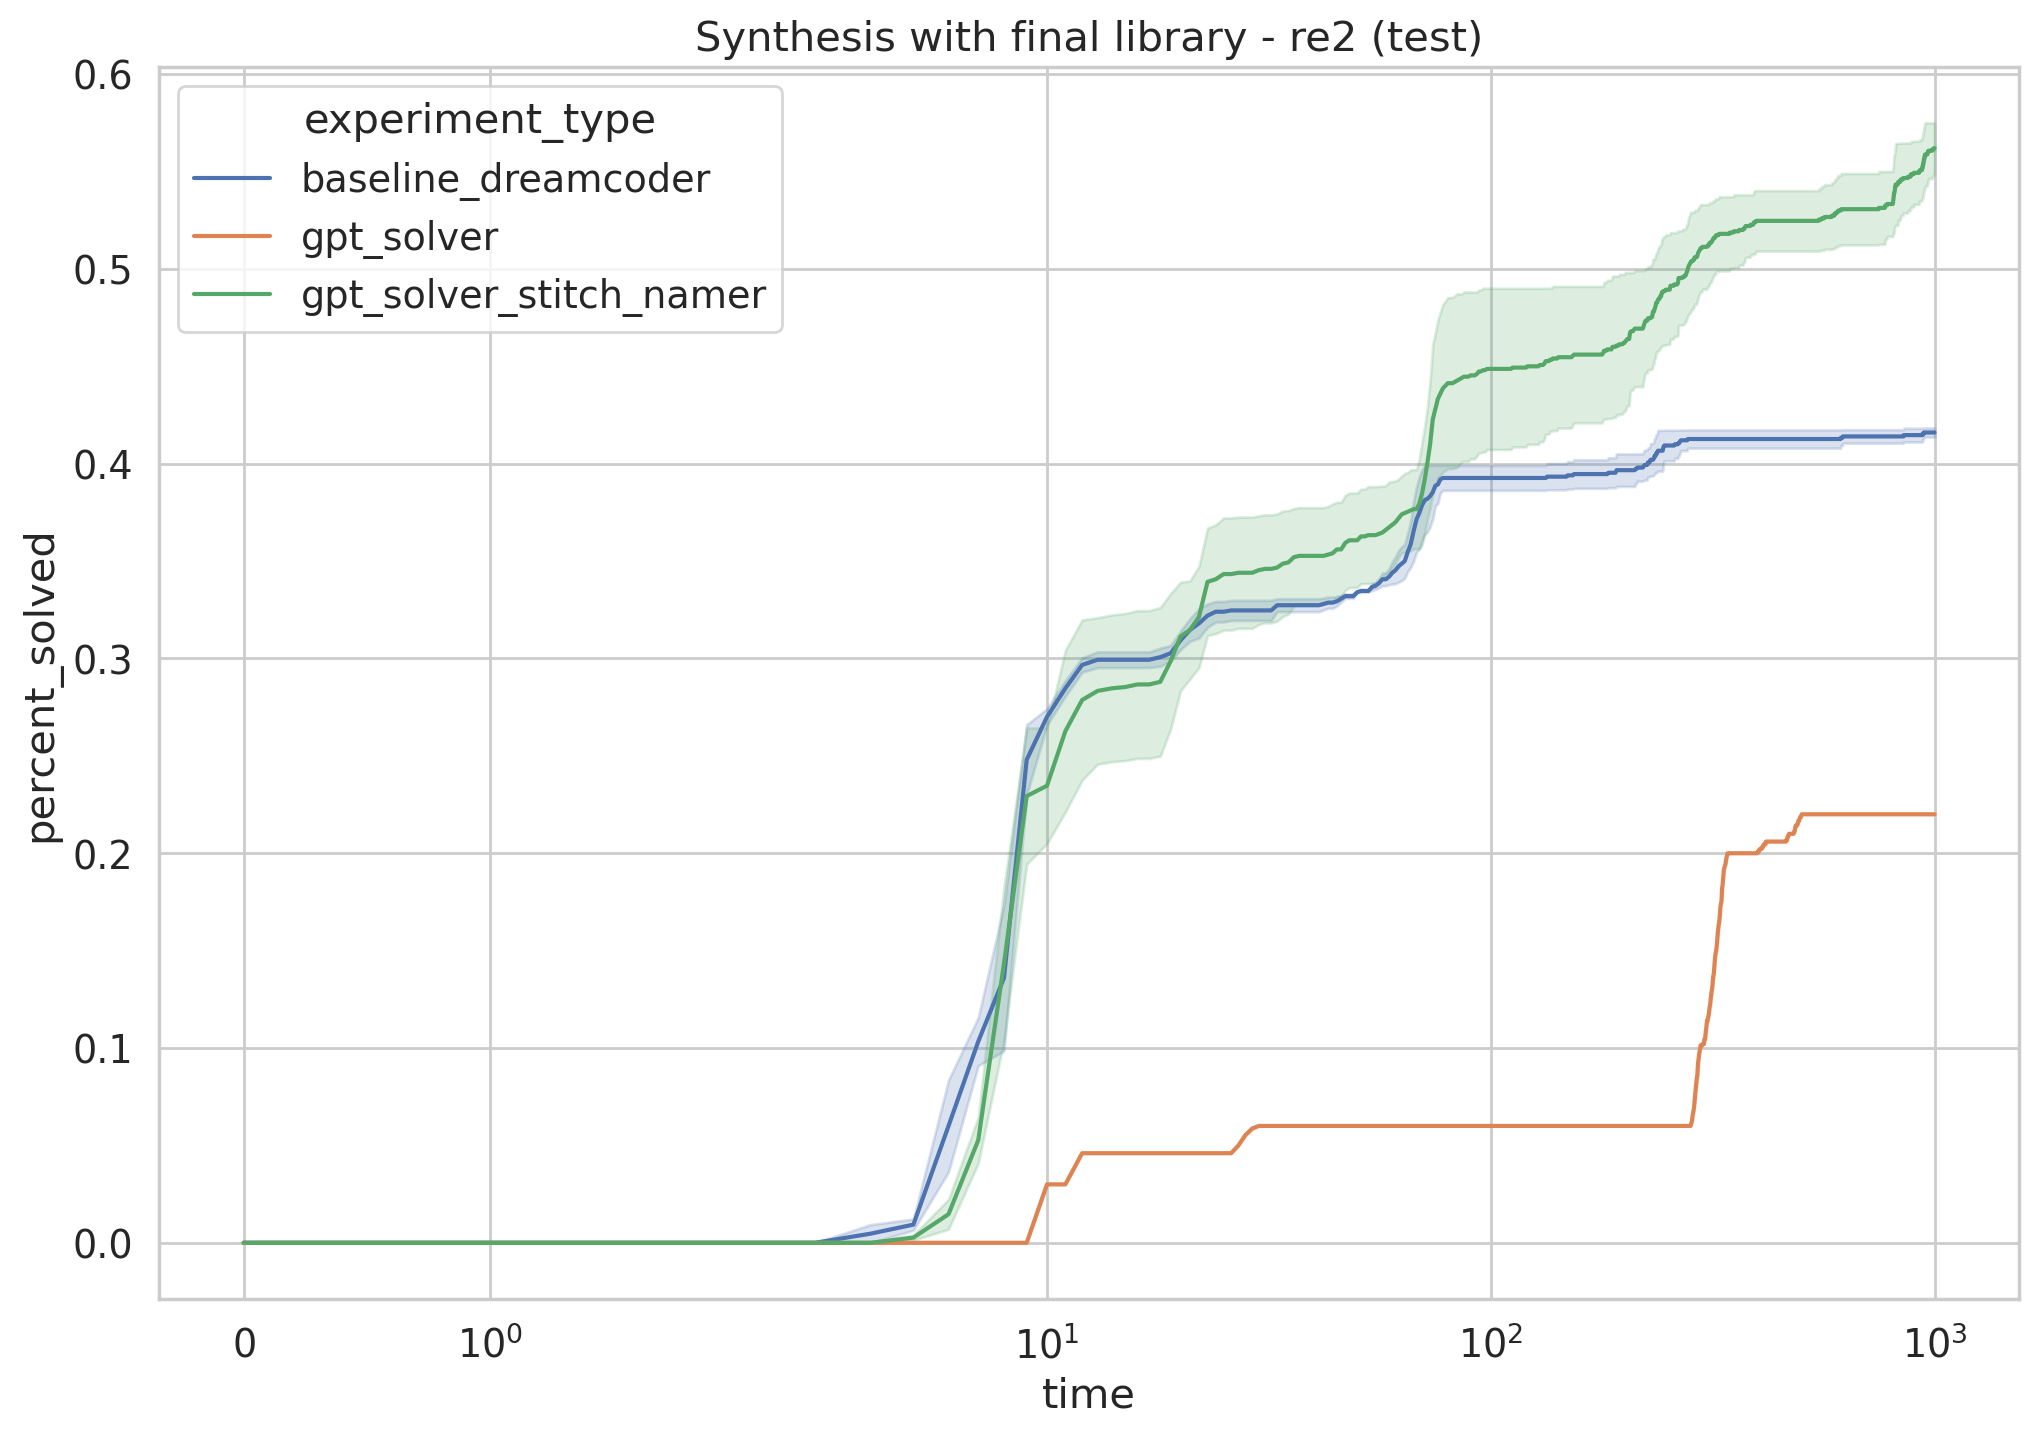

In [17]:
g = sns.lineplot(
    data=df_search_time[df_search_time.split == "test"],
    x="time",
    y="percent_solved",
    hue="experiment_type",
    legend="full",
    errorbar="se",
)
g.set(xscale='symlog')
plt.title(f"Synthesis with final library - {DOMAIN} (test)"); 